In [34]:
import random
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from termcolor import colored, cprint
import matplotlib.pyplot as plt


In [35]:
# Hyperparameters

opts = {}

# Data settings
opts['num_train_samples'] = 50
opts['num_test_samples'] = 100
opts['vocab_size'] = 1000 # Number of tokens in vocabulary

# Model and ML settings
opts['hidden_layer_size']=50
opts['learning_rate']=1e-4
opts['epochs']=100
opts['batch_size']=1

# Data

In [36]:
# Vocabulary. Useful for converting words to tokens and vice versa.
# Adapted from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#sphx-glr-intermediate-seq2seq-translation-tutorial-py

class Vocabulary:
    def __init__(self):
        self.word2id = {}
        self.id2word = {}
        self.n_words = 0
        
    def add_word(self, word):
        if word not in self.word2id:
            self.word2id[word] = self.n_words
            self.id2word[self.n_words] = word
            self.n_words += 1
            
vocab = Vocabulary()  

In [37]:
# A toy dataset mapping x=some number to a set Y=[0,1]

def create_number_to_bimodal_data(num_samples, vocab_size, vocab):
    data = []  # Each row will contain (x, [y, y', ...])

    # Create vocab
    for i in range(vocab_size):
        vocab.add_word(str(i)) # if not already there
    
    # Create data
    special_token_1 = vocab.word2id[str(0)]
    special_token_2 = vocab.word2id[str(1)]
    for i in range(num_samples):
        x = 7
        x_token = vocab.word2id[str(x)]
        data.append((x_token, [special_token_1, special_token_2]))    
    return data

train_data = create_number_to_bimodal_data(opts['num_train_samples'], opts['vocab_size'], vocab)
test_data = create_number_to_bimodal_data(opts['num_test_samples'], opts['vocab_size'], vocab)
print('data:',train_data[0:3],'...')

data: [(7, [0, 1]), (7, [0, 1]), (7, [0, 1])] ...


In [38]:
# Data processing

def mark_onehot(i, empty_onehot):
    empty_onehot.zero_()
    empty_onehot.scatter_(1,torch.tensor([[i]]),1) # e.g. [0,0,1,0]

onehot = torch.FloatTensor(1, vocab.n_words)
def prep_x(x):
    mark_onehot(x, onehot) # e.g. [0,0,1,0]
    return onehot

def prep_y(y):
    return torch.LongTensor([y]) # e.g. y=[[2,0]]

print('processed sample:', prep_x(train_data[0][0]), prep_y(train_data[0][1]))

processed sample: tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0

# Helper

In [39]:
# Write and loss,or loss
class AndLoss(torch.nn.Module):
    def __init__(self):
        super(AndLoss, self).__init__()

    def forward(self, prediction, target):
        target_onehot = torch.FloatTensor(opts['batch_size'], vocab.n_words-1)
        target_onehot.zero_()
        target_onehot.scatter_(1, target, 1)   
        loss = torch.log1p(prediction) * target_onehot
        loss = -1 * torch.sum(loss)/opts['batch_size']  #Average loss across samples
        return loss

class OrLoss(torch.nn.Module):
    def __init__(self):
        super(OrLoss, self).__init__()

    def forward(self, prediction, target):
        target_onehot = torch.FloatTensor(opts['batch_size'], vocab.n_words-1)
        target_onehot.zero_()
        target_onehot.scatter_(1, target, 1)   
        loss = prediction * target_onehot
        loss = -1 * torch.log1p(torch.sum(loss))  #Per sample loss
#         print(loss)
        loss = loss/opts['batch_size']  #Average loss across samples
        return loss
    
class MaxLoss(torch.nn.Module):
    def __init__(self):
        super(MaxLoss, self).__init__()

    def forward(self, prediction, target):
        target_onehot = torch.FloatTensor(opts['batch_size'], vocab.n_words-1)
        target_onehot.zero_()
        target_onehot.scatter_(1, target, 1)   
        loss = prediction * target_onehot
        loss = -1 * torch.log1p(torch.max(loss))  #Per sample loss
        loss = loss/opts['batch_size']  #Average loss across samples
        return loss
    
    
and_criterion = AndLoss()
or_criterion = OrLoss()
max_criterion = MaxLoss()

def official_criterion(prediction, target):
    squeezed_target = target.squeeze()
    nll = torch.nn.NLLLoss()
    return nll(torch.log1p(prediction), squeezed_target)

In [40]:
# # Show they match when only 1 y
# prediction = Variable(torch.rand(opts['batch_size'], vocab.n_words).float())
# print('pred '+str(prediction))
# target = Variable(torch.FloatTensor(opts['batch_size'],3).uniform_(0, vocab.n_words).long())
# print('target '+str(target))

# and_loss = and_criterion(prediction, target)
# print('and loss '+str(and_loss))
# or_loss = or_criterion(prediction, target)
# print('or loss '+str(or_loss))
# # official_loss = official_criterion(prediction,target)
# # print('loss '+str(official_loss))

In [41]:
# Define simple neural net
def get_new_model():
    model = torch.nn.Sequential(
    torch.nn.Linear(vocab.n_words, opts['hidden_layer_size']),
    torch.nn.ReLU(),
    torch.nn.Linear(opts['hidden_layer_size'], 2),
    torch.nn.Softmax(), # TODO double check need for softmax
    )
    return model

# Define training
def train(data, model, criterion, opts, verbose=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=opts['learning_rate'])
    running_loss=0.0
    for epoch in range(opts['epochs']):
        for (x,y) in data:
            x = prep_x(x)
            y = prep_y(y)
            # Forward pass: compute predicted y
            y_pred = model(x) 
            loss = criterion(y_pred, y)
            # Backward pass: compute gradient of the loss with respect to model
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()
            # For printing stats
            running_loss += loss.item()
        if verbose: print('[Epoch %d] loss: %.3f' % (epoch, running_loss))
        running_loss = 0.0
        
# Define testing
def test(x, model, vocab):
    output = model(x)
    prediction_index = torch.argmax(output)
#     prediction = vocab.index2word[prediction_index.item()]
    return int(prediction_index.item())

In [42]:
class FontColors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# Compare results

In [43]:
def evaluate_criterion(criterion):
    print("Training...")
    train(train_data, model, criterion, opts, verbose=False)


    print("Performance on Train set")
    font_color = FontColors.ENDC
    num_correct = 0
    for (x,y) in train_data: # Train data
        prediction = test(prep_x(x), model, vocab)
        is_correct = int(prediction) in y
        if is_correct:
            num_correct = num_correct + 1
            font_color = FontColors.OKGREEN
        print(font_color, x, y, '-->', prediction, is_correct, FontColors.ENDC)
        font_color = FontColors.ENDC
    print(num_correct/opts['num_train_samples'])


    print("Performance on Test set")
    font_color = FontColors.ENDC
    num_correct = 0
    predictions = []
    for (x,y) in test_data: # Train data
        prediction = test(prep_x(x), model, vocab)
        predictions.append(vocab.id2word[prediction])
        is_correct = int(prediction) in y
        if is_correct:
            num_correct = num_correct + 1
            font_color = FontColors.OKGREEN
        print(font_color, x, y, '-->', prediction, is_correct, FontColors.ENDC)
        font_color = FontColors.ENDC
    print(num_correct/opts['num_test_samples'])
    
    plt.hist(predictions)
    plt.axis([0,1,0,opts['num_test_samples']])
#     plt.xlabel('Prediction')
    plt.show()

In [44]:
model = get_new_model()

In [45]:
evaluate_criterion(and_criterion)

Training...


RuntimeError: The size of tensor a (2) must match the size of tensor b (999) at non-singleton dimension 1

In [20]:
model = get_new_model()

Training...
Performance on Train set
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 True 
 0 [0, 1] --> 1 T

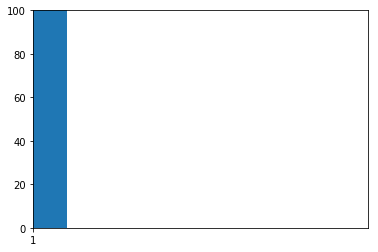

In [21]:
evaluate_criterion(or_criterion)

In [60]:
model = get_new_model()

Training...


/Users/pkalluri/env/lib/python3.6/site-packages/torch/nn/modules/container.py:91: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Performance on Train set
 117 [0, 1] --> 0 True 
 129 [0, 1] --> 0 True 
 770 [0, 1] --> 0 True 
 363 [0, 1] --> 0 True 
 33 [0, 1] --> 0 True 
 435 [0, 1] --> 0 True 
 734 [0, 1] --> 0 True 
 520 [0, 1] --> 0 True 
 633 [0, 1] --> 0 True 
 248 [0, 1] --> 0 True 
 614 [0, 1] --> 0 True 
 456 [0, 1] --> 0 True 
 738 [0, 1] --> 0 True 
 795 [0, 1] --> 0 True 
 98 [0, 1] --> 0 True 
 767 [0, 1] --> 0 True 
 24 [0, 1] --> 0 True 
 514 [0, 1] --> 0 True 
 702 [0, 1] --> 0 True 
 602 [0, 1] --> 0 True 
 997 [0, 1] --> 0 True 
 839 [0, 1] --> 0 True 
 997 [0, 1] --> 0 True 
 476 [0, 1] --> 0 True 
 848 [0, 1] --> 0 True 
 577 [0, 1] --> 0 True 
 622 [0, 1] --> 0 True 
 57 [0, 1] --> 0 True 
 180 [0, 1] --> 0 True 
 142 [0, 1] --> 0 True 
 572 [0, 1] --> 0 True 
 832 [0, 1] --> 0 True 
 865 [0, 1] --> 0 True 
 357 [0, 1] --> 0 True 
 411 [0, 1] --> 0 True 
 77 [0, 1] --> 0 True 
 493 [0, 1] --> 0 True 
 345 [0, 1] --> 0 True 
 121 [0, 1] --> 0 True 
 179 [0, 1] --> 0 True 
 649 [0, 1] --> 0 Tr

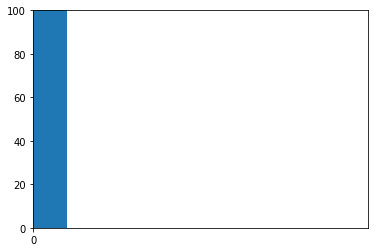

In [61]:
evaluate_criterion(max_criterion)